In [3]:
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

SHOW_RATIO = True

def bar_chart(ax, algorithms, normalize_by=None):
    names = [x['algorithm']['name'] for x in algorithms]
    expected_results = [x.get('expected_makespan') for x in algorithms]
    actual_results = [x['makespan'] for x in algorithms]
    if SHOW_RATIO:
        ratios = [x['exec_time'] / x['comm_time'] for x in algorithms]
    else:
        ratios = [None] * len(algorithms)
    if normalize_by:
        actual_results = [x/normalize_by for x in actual_results]
        expected_results = [x/normalize_by for x in expected_results]
        plt.plot([-0.5, len(names)-0.5], [1, 1], color='#C44E52', linewidth=4)
    for i, (expected, actual, ratio) in enumerate(zip(expected_results, actual_results, ratios)):
        if not math.isnan(expected):
            ax.add_patch(Rectangle((-0.4+i, 0), 0.38, expected, color='#55A868'))
            if SHOW_RATIO:
                ax.add_patch(Rectangle(( 0.02 +i, 0), 0.38, actual*ratio, color='#DD8452'))
                ax.add_patch(Rectangle(( 0.02 +i, actual*ratio), 0.38, actual*(1-ratio), color='#4C72B0'))
            else:
                ax.add_patch(Rectangle(( 0.02 +i, 0), 0.38, actual, color='#4C72B0'))
        else:
            ax.add_patch(Rectangle((-0.4+i, 0), 0.8, actual, color='#4C72B0'))
    plt.xlim(-0.5, len(names)-0.5)
    plt.xticks(range(len(names)), names)

In [4]:
def groupby(values, key, apply=None):
    grouped = {}
    for x in values:
        grouped.setdefault(key(x), [])
        grouped[key(x)].append(x)
    if apply:
        for k in grouped:
            grouped[k] = apply(grouped[k])
    return grouped

In [17]:
def get_name_by_path(path):
    return path.split("/")[-1].rsplit('.', 1)[0]

def platform_sort_key(item):
    return platform_order.index(get_name_by_path(item[0]))

def algo_sort_key(item):
    return algo_order.index(item['algorithm']['name'])

platform_order = [
    'platform_rack_4', 'platform_rack_8', 'platform_rack_16',
    'platform_cluster_2', 'platform_cluster_4', 'platform_cluster_8',
    'simple_4',
]
algo_order = ['HEFT', 'EHEFT', 'EHEFT_caching', 'LA', 'ELA', 'ELA_caching']

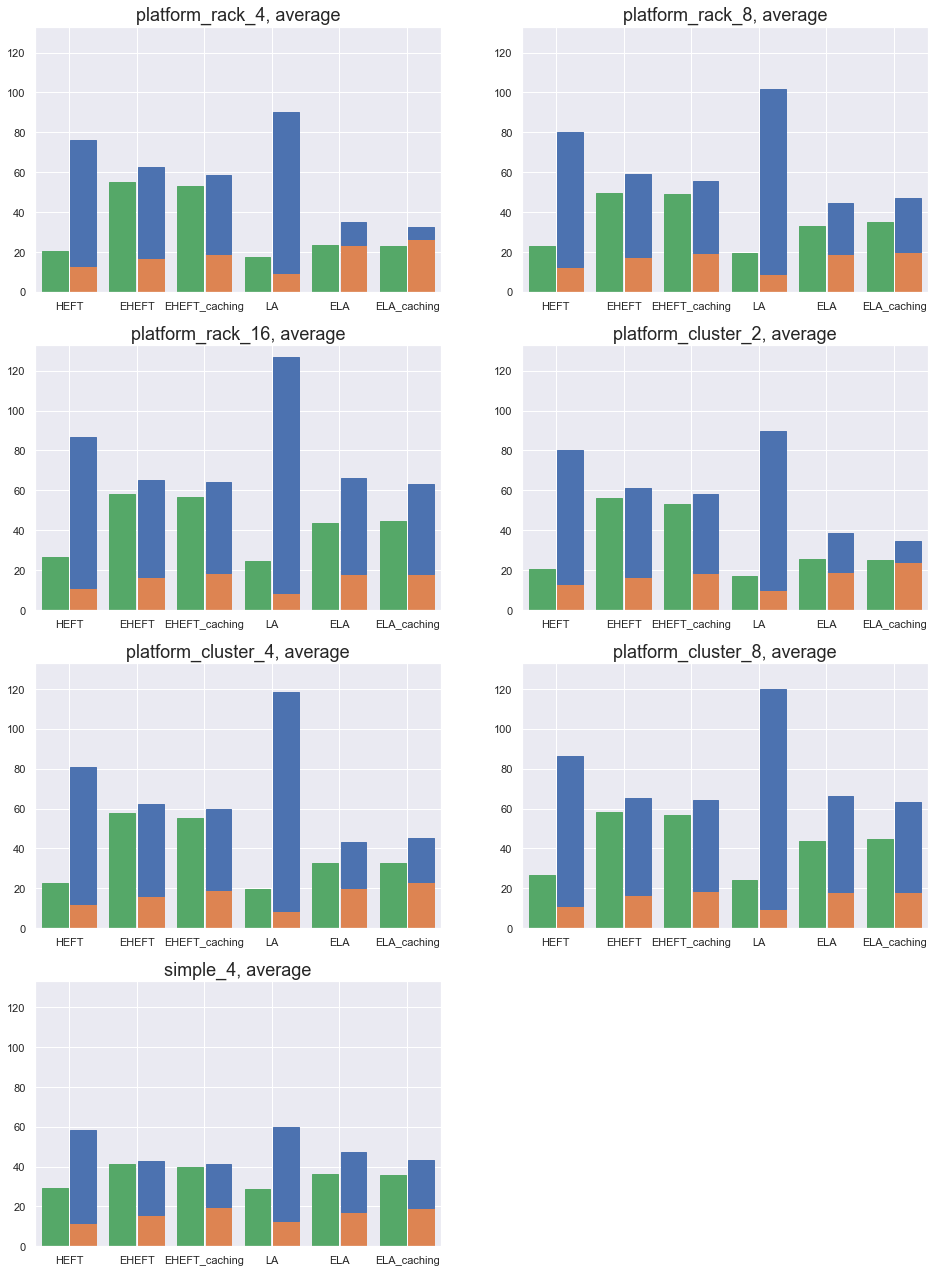

In [18]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = get_name_by_path(x['tasks'])
    x['platform'] = get_name_by_path(x['platform'])
    
def mean_fn(value):
    return {
        'expected_makespan': sum([x['expected_makespan'] for x in value]) / len(value),
        'makespan': sum([x['makespan'] for x in value]) / len(value),
        'exec_time': sum([x['exec_time'] for x in value]) / len(value),
        'comm_time': sum([x['comm_time'] for x in value]) / len(value),
        'algorithm': {'name': value[0]['algorithm']['name']},
        'platform': value[0]['platform'],
        'tasks': 'average',
    }
mean = groupby(results, key=lambda r:(r['platform'], r['algorithm']['name']), apply=mean_fn)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(16, 40))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
        expected = [x['expected_makespan'] for x in platform_results if not math.isnan(x['expected_makespan'])] or [max_res]
        max_res = max(
             max_res,
             max([x['makespan'] for x in platform_results]),
             max(expected)
         )
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow)*len(workflow_results), 2, counter)
        plt.ylim(top=max_res*1.05)
        bar_chart(ax, sorted(platform_results, key=algo_sort_key))
        plt.title(f'{platform}, {workflow}', fontsize=18)
        counter += 1

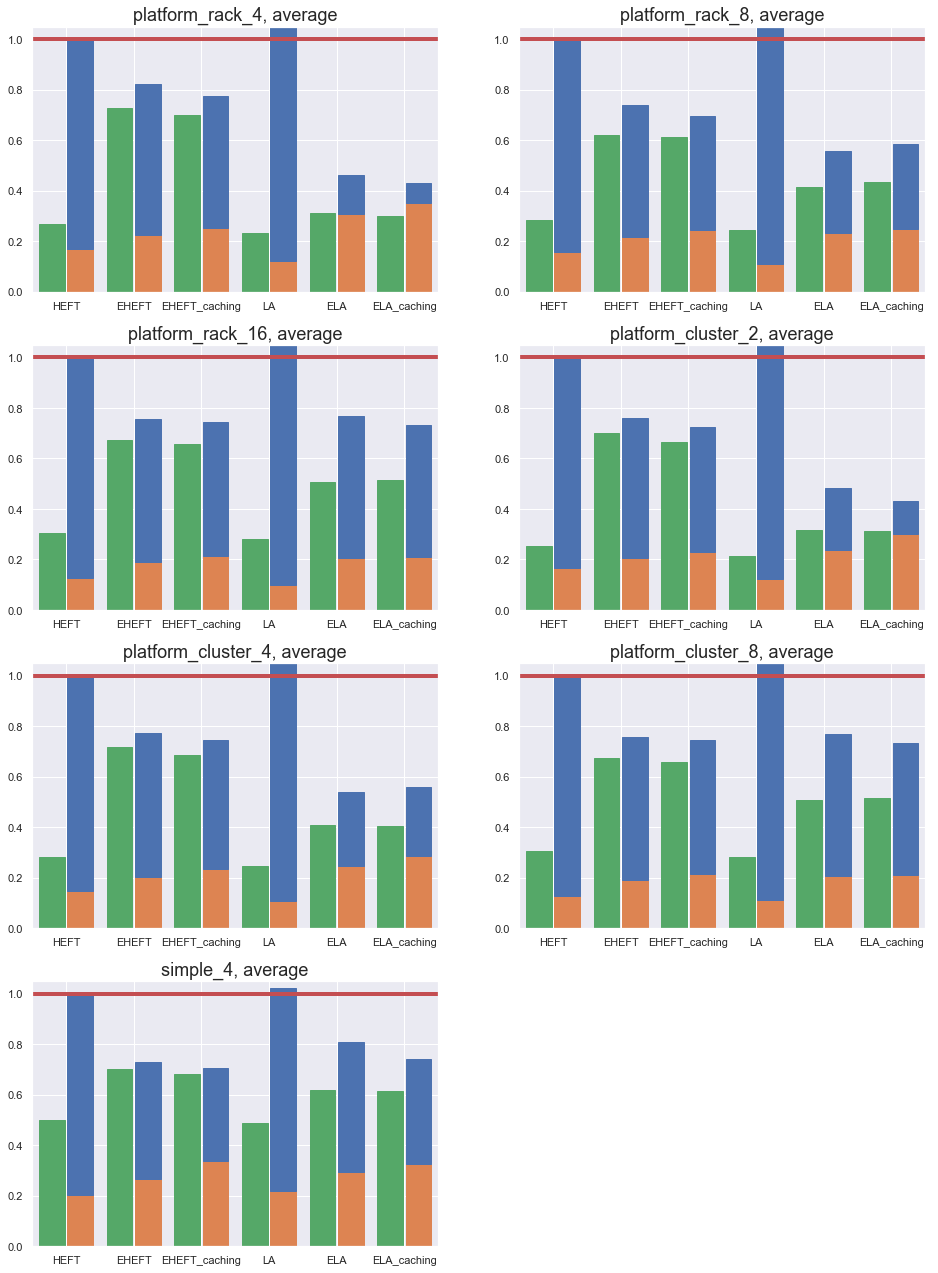

In [21]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-4/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = get_name_by_path(x['tasks'])
    x['platform'] = get_name_by_path(x['platform'])
    
def mean_fn(value):
    return {
        'expected_makespan': sum([x['expected_makespan'] for x in value]) / len(value),
        'makespan': sum([x['makespan'] for x in value]) / len(value),
        'exec_time': sum([x['exec_time'] for x in value]) / len(value),
        'comm_time': sum([x['comm_time'] for x in value]) / len(value),
        'algorithm': {'name': value[0]['algorithm']['name']},
        'platform': value[0]['platform'],
        'tasks': 'average',
    }
mean = groupby(results, key=lambda r:(r['platform'], r['algorithm']['name']), apply=mean_fn)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(16, 40))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
         max_res = max(max_res, max([x['makespan'] for x in platform_results]))
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow)*len(workflow_results), 2, counter)
        baseline = platform_results[0]['makespan']
        plt.ylim(top=1.05)
        bar_chart(ax, sorted(platform_results, key=algo_sort_key), normalize_by=baseline)
        plt.title(f'{platform}, {workflow}', fontsize=18)
        counter += 1